# Survival Prediction of Lung Cancer Patients Based on Different Feature Selection Methods Using DeepSurv Models

## Import the Libraries

In [32]:
pip install lifelines

In [33]:
import pandas as pd
import numpy as np
import tensorflow as tf
import requests
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index

## Fuctions to prepare the dataset

### Load clinical data

In [34]:
def load_clinical_data(cancer, base_path):
  print(f'==========LOAD {cancer} CLINICAL DATA==========')
  clinical_data = pd.read_csv(f'{base_path}{cancer.lower()}_clinical_patient.txt', sep='\t')

  # Select the relevant columns for analysis
  clinical_data = clinical_data[['Patient Identifier', 'Overall Survival Status', 'Overall Survival (Months)']].loc[4:]
  clinical_data = clinical_data.rename(columns = {'Overall Survival Status' : 'OS_STATUS', 'Overall Survival (Months)' : 'OS_MONTHS'})

  # Conver OS_MONTHS values into binary format(1 for deceased, 0 for living)
  clinical_data["OS_STATUS"] = clinical_data["OS_STATUS"].apply(lambda x : 1 if x.find('1:') != -1 else 0)

  # Drop rows where OS_MONTHS is 0 or [Not Available]
  clinical_data = clinical_data[(clinical_data['OS_MONTHS'] != '0') & (clinical_data['OS_MONTHS'] != '[Not Available]')]

  # Reset the index to start from 0
  clinical_data = clinical_data.reset_index(drop=True)

  return clinical_data

### Load gene data

In [35]:
def load_gene_data(cancer, base_path):
  print(f'==========LOAD {cancer} GENE DATA==========')
  gene_data = pd.read_csv(f'{base_path}{cancer.lower()}_gene_data.txt', sep='\t').T

  # Change the column name as gene symbol
  gene_data.columns = gene_data.iloc[0]
  gene_data = gene_data.drop(['Hugo_Symbol', 'Entrez_Gene_Id'])
  gene_data = gene_data.astype(float)

  # Drop columns with any NaN values
  gene_data = gene_data.dropna(axis=1)

  # Remove the last '-01' part in index
  gene_data.index = gene_data.index.astype(str)
  gene_data.index = gene_data.index.str.replace(r'-\d+$', '', regex=True)

  # Check and control the duplicated genes
  duplicated_genes = gene_data.columns[gene_data.columns.duplicated()]

  for gene in duplicated_genes:
    var_gene = np.var(gene_data[gene])

    if var_gene.values[0] < var_gene.values[1]:
      gene_data[gene] = gene_data[gene].iloc[:, 1]
    else:
      gene_data[gene] = gene_data[gene].iloc[:, 0]

  gene_data = gene_data.iloc[:, ~gene_data.columns.duplicated()]

  return gene_data

## Feature Selection

### 1. Variance-based Univariate Selection(Top 500)

In [36]:
def variance_selection(gene_data):
  # Calculate variance by column
  variances = gene_data.var(axis=0)
  top_100_variance = variances.sort_values(ascending=False).head(100)

  return top_100_variance.index

### 2. Specific gene data

In [37]:
def specific_gene_selection(gene_data):
    gene_list = ['ANLN', 'RACGAP1', 'KIF4A', 'KIF20A', 'KIF14',
                 'ASPM', 'CDK1', 'SPC25', 'NCAPG', 'MKI67',
                 'HJURP', 'EXO1', 'HMMR']
    return [gene for gene in gene_list if gene in gene_data.columns]

### 3. KEGG pathway - wnt signaling

In [38]:
def kegg_pathway_wnt_selection(gene_data):
    url = f"http://rest.kegg.jp/get/ko04310"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.text
        lines = data.strip().split('\n')

        orthology_genes = []
        orthology_started = False

        for line in lines:
            if line.startswith("ORTHOLOGY"):
                orthology_started = True
                parts = line.strip().split()
                if len(parts) >= 3:
                    gene = parts[2].split(";")[0]
                    orthology_genes.append(gene)
            elif orthology_started and line.startswith("            "):
                parts = line.strip().split()
                if len(parts) >= 2:
                    gene = parts[1].split(";")[0]
                    orthology_genes.append(gene)
            elif orthology_started and not line.startswith("            "):
                break  # ORTHOLOGY block ended

        # return orthology_genes
        return [gene for gene in orthology_genes if gene in gene_data.columns]

    else:
        print(f"Error fetching KEGG pathway details: {response.status_code}")
        return []

### 4. KEGG pathway - small cell lung cancer

In [39]:
def kegg_pathway_lung_selection(gene_data):
    url = f"http://rest.kegg.jp/get/ko05222"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.text
        lines = data.strip().split('\n')

        orthology_genes = []
        orthology_started = False

        for line in lines:
            if line.startswith("ORTHOLOGY"):
                orthology_started = True
                parts = line.strip().split()
                if len(parts) >= 3:
                    gene = parts[2].split(";")[0]
                    orthology_genes.append(gene)
            elif orthology_started and line.startswith("            "):
                parts = line.strip().split()
                if len(parts) >= 2:
                    gene = parts[1].split(";")[0]
                    orthology_genes.append(gene)
            elif orthology_started and not line.startswith("            "):
                break  # ORTHOLOGY block ended

        # return orthology_genes
        return [gene for gene in orthology_genes if gene in gene_data.columns]

    else:
        print(f"Error fetching KEGG pathway details: {response.status_code}")
        return []

### 5. KEGG pathway - cancer

In [40]:
def kegg_pathway_cancer_selection(gene_data):
    url = f"http://rest.kegg.jp/get/ko05200"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.text
        lines = data.strip().split('\n')

        orthology_genes = []
        orthology_started = False

        for line in lines:
            if line.startswith("ORTHOLOGY"):
                orthology_started = True
                parts = line.strip().split()
                if len(parts) >= 3:
                    gene = parts[2].split(";")[0]
                    orthology_genes.append(gene)
            elif orthology_started and line.startswith("            "):
                parts = line.strip().split()
                if len(parts) >= 2:
                    gene = parts[1].split(";")[0]
                    orthology_genes.append(gene)
            elif orthology_started and not line.startswith("            "):
                break  # ORTHOLOGY block ended

        # return orthology_genes
        return [gene for gene in orthology_genes if gene in gene_data.columns]

    else:
        print(f"Error fetching KEGG pathway details: {response.status_code}")
        return []

### 4. Reactome pathway

In [41]:
# def reactome_pathway_selection(gene_data):

### 5. Cascaded Wx

In [42]:
# def cascaded_wx_selection(gene_data):

## Merge the clinical data and the gene data

In [43]:
def merge_data(gene_data, clinical_data):
  merge_data = pd.merge(gene_data,
                         clinical_data,
                         left_on=gene_data.index,
                         right_on='Patient Identifier',
                         how='inner')
  return merge_data

## Model - DeepSurv

In [44]:
class DeepSurv(nn.Module):
    def __init__(self, input_dim):
        super(DeepSurv, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


## Loss function

In [45]:
def neg_log_partial_likelihood(risk_scores, durations, events):
    order = torch.argsort(durations, descending=True)
    durations = durations[order]
    events = events[order]
    risk_scores = risk_scores[order]

    hazard_ratio = torch.exp(risk_scores)
    log_cumsum = torch.log(torch.cumsum(hazard_ratio, dim=0) + 1e-8)
    uncensored_loss = (risk_scores - log_cumsum) * events
    return -torch.mean(uncensored_loss)

## C-index

In [46]:
def c_index(model, x, time, event):
  model.eval()
  with torch.no_grad():
    risk_scores = model(x).detach().numpy().flatten()
  return concordance_index(time.numpy(), -risk_scores, event.numpy())

## Plot

In [47]:
def loss_graph(train_losses, val_losses):
  plt.figure(figsize=(10, 5))
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('DeepSurv Training vs Validation Loss')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

## Main

==========LOAD LUAD CLINICAL DATA==========
==========LOAD LUAD GENE DATA==========


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)



========== Running with variance feature selection ==========
Early stopping at epoch 297

Final Validation C-index: 0.5203


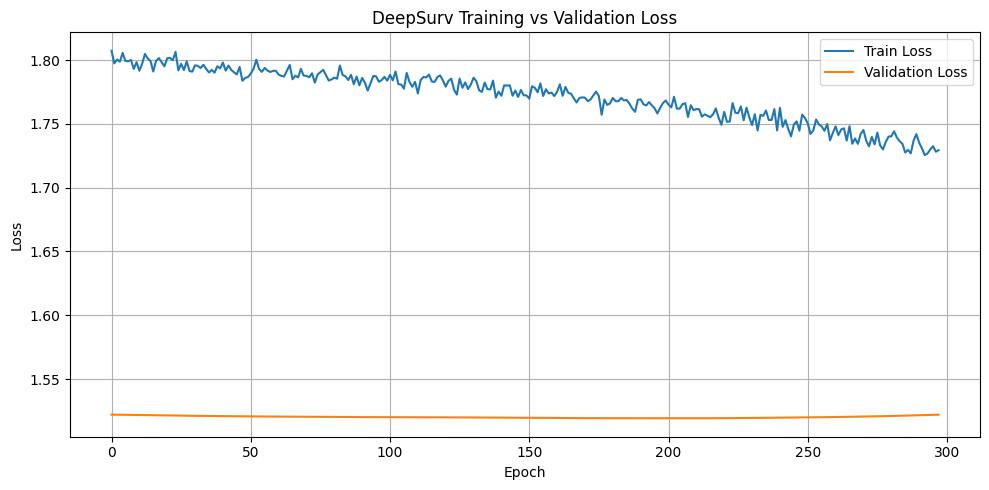


========== Running with specific_gene feature selection ==========
Early stopping at epoch 932

Final Validation C-index: 0.6057


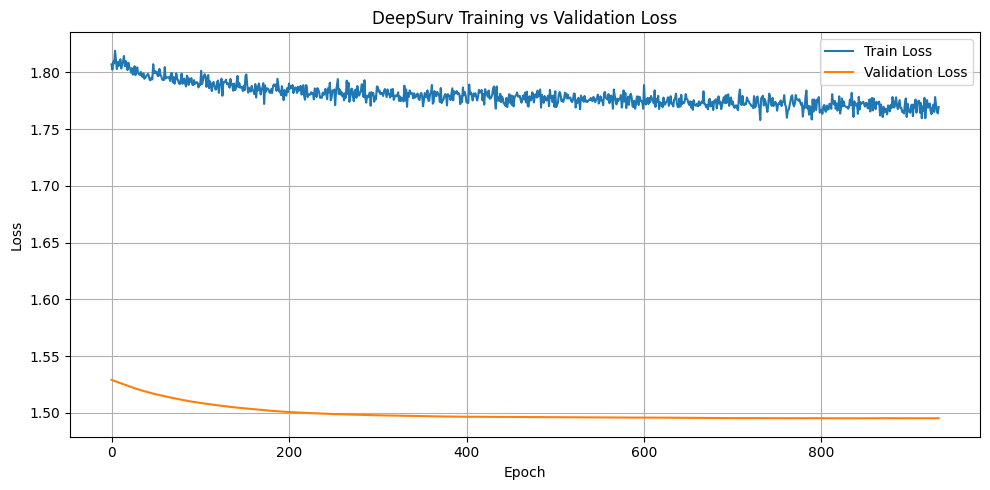


========== Running with kegg_wnt feature selection ==========
Early stopping at epoch 385

Final Validation C-index: 0.6068


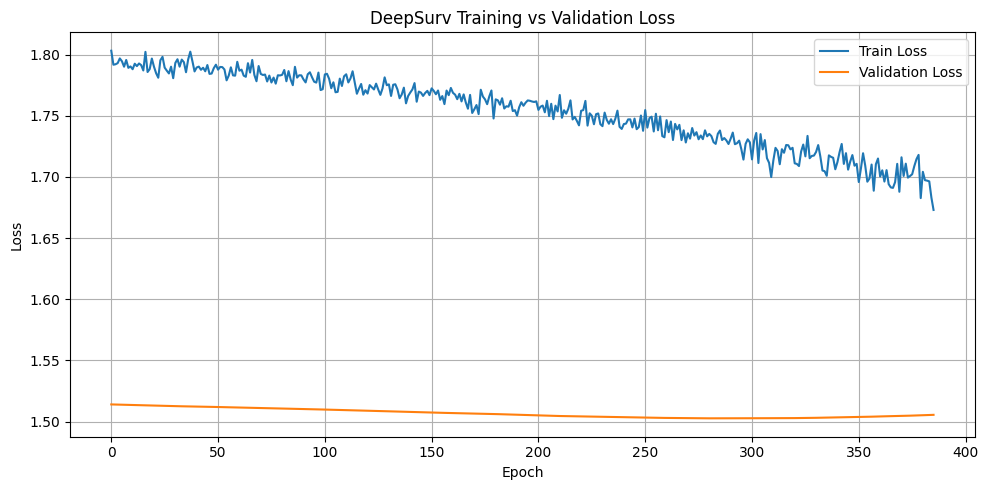


========== Running with kegg_cancer feature selection ==========
Early stopping at epoch 243

Final Validation C-index: 0.5539


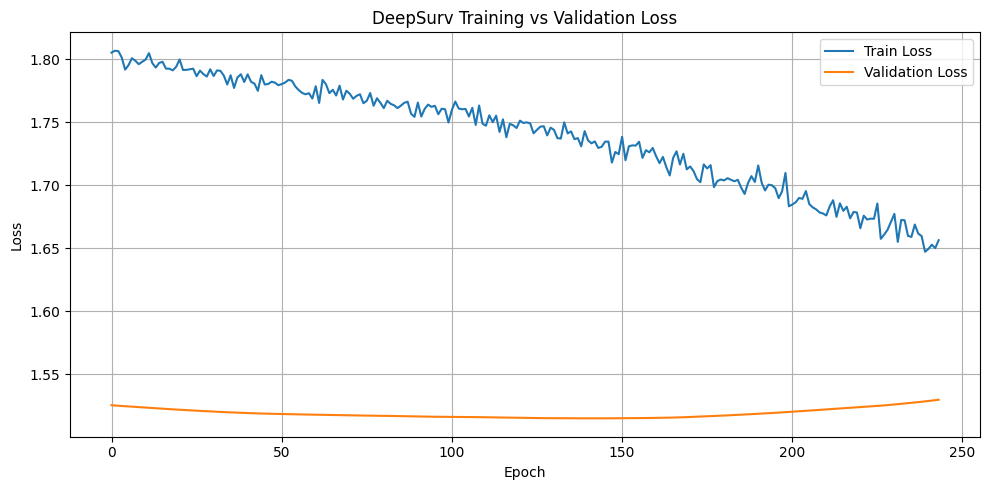


========== Running with kegg_lung feature selection ==========
Early stopping at epoch 683

Final Validation C-index: 0.5551


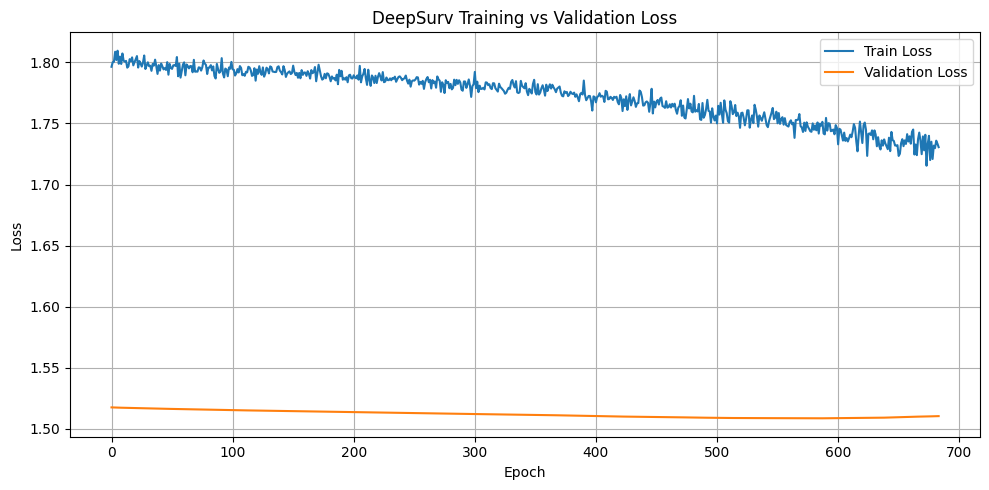

==========LOAD LUSC CLINICAL DATA==========
==========LOAD LUSC GENE DATA==========


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)



========== Running with variance feature selection ==========
Early stopping at epoch 589

Final Validation C-index: 0.6081


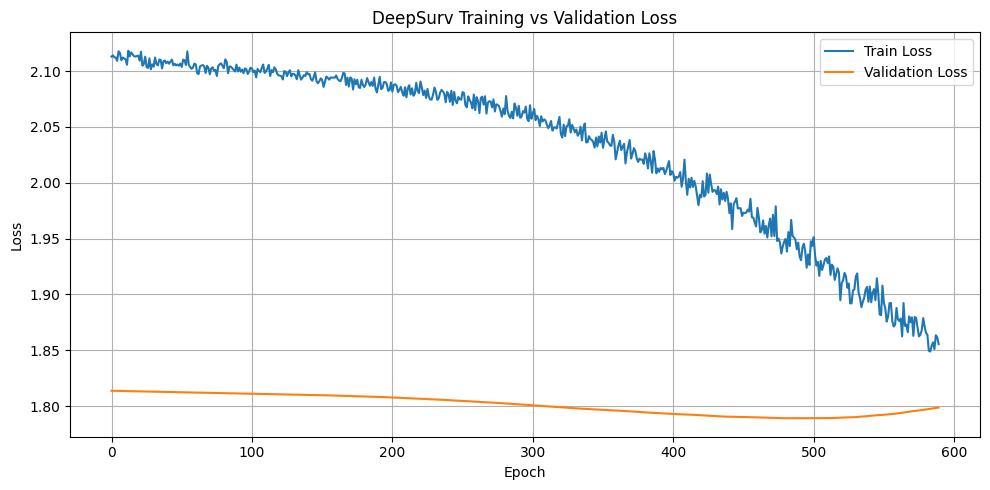


========== Running with specific_gene feature selection ==========
Early stopping at epoch 100

Final Validation C-index: 0.5421


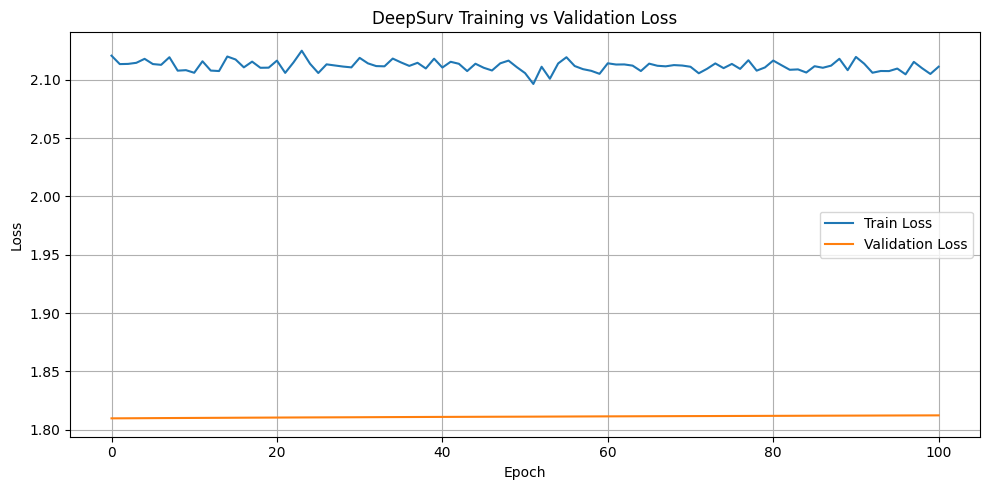


========== Running with kegg_wnt feature selection ==========
Early stopping at epoch 212

Final Validation C-index: 0.4568


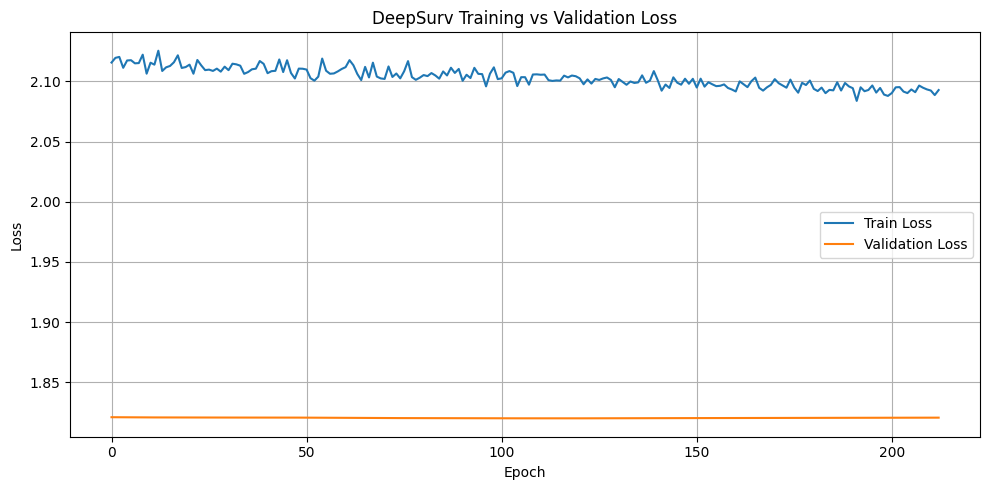


========== Running with kegg_cancer feature selection ==========
Early stopping at epoch 100

Final Validation C-index: 0.4792


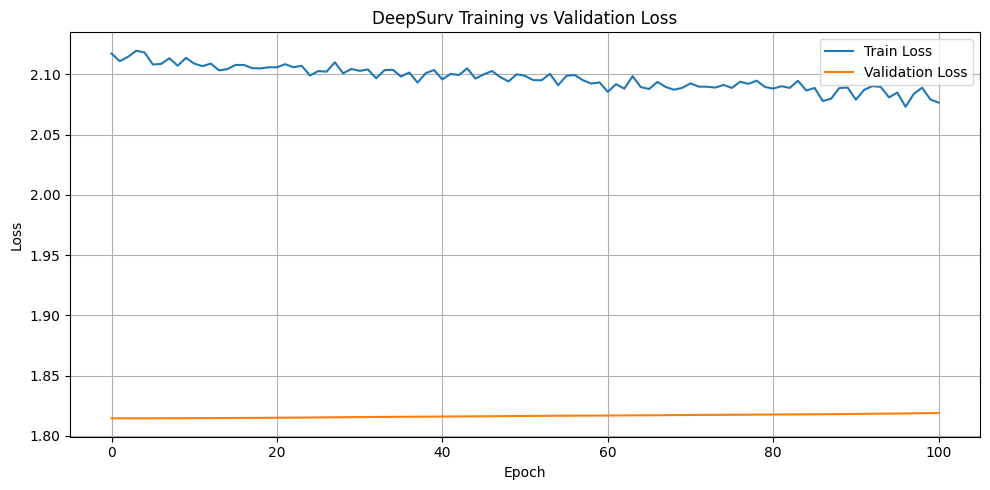


========== Running with kegg_lung feature selection ==========
Early stopping at epoch 100

Final Validation C-index: 0.5225


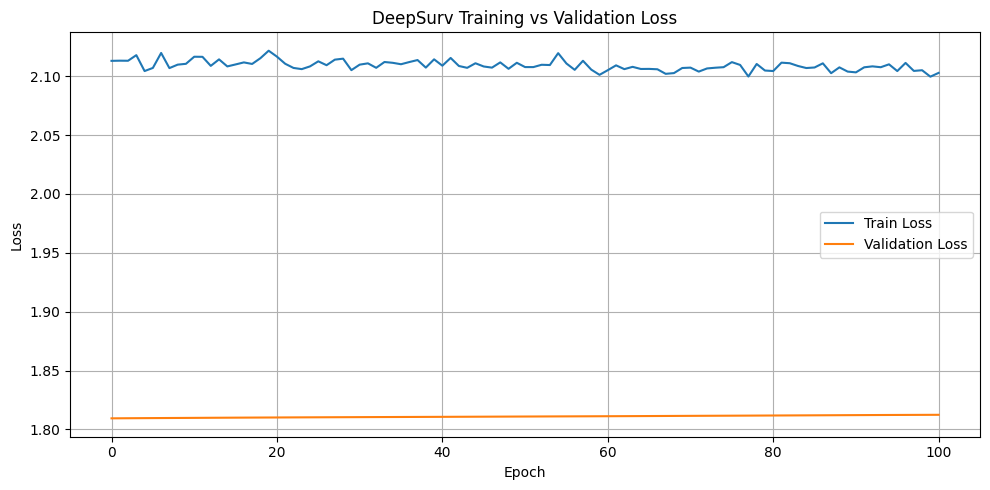

In [48]:
cancer_names = ['LUAD', 'LUSC']    # add LUSC
base_path = '/content/'
feature_selection_methods = ['variance', 'specific_gene', 'kegg_wnt', 'kegg_cancer', 'kegg_lung']

for cancer in cancer_names:
  clinical_data = load_clinical_data(cancer, base_path)
  gene_data = load_gene_data(cancer, base_path)

  for method in feature_selection_methods:
    print(f'\n========== Running with {method} feature selection ==========')

    # Feature selection
    if method == 'variance':
      selected_features = variance_selection(gene_data)
    elif method == 'specific_gene':
      selected_features = specific_gene_selection(gene_data)
    elif method == 'kegg_wnt':
      selected_features = kegg_pathway_wnt_selection(gene_data)
    elif method == 'kegg_cancer':
      selected_features = kegg_pathway_cancer_selection(gene_data)
    elif method == 'kegg_lung':
      selected_features = kegg_pathway_lung_selection(gene_data)
    # elif method == 'reactome':
    #   selected_features = reactome_pathway_selection(gene_data)
    # elif method == 'cascaded_wx':
    #   selected_features = cascaded_wx_selection(gene_data)

    # Merge with clinical dataset
    selected_gene_data = gene_data[selected_features]
    merged_data = merge_data(selected_gene_data, clinical_data)

    # Split E, Y
    E = np.array(merged_data["OS_STATUS"])
    Y = np.array(merged_data["OS_MONTHS"])

    # Extract only gene features
    gene_columns = [col for col in merged_data.columns if col not in ["OS_STATUS", "OS_MONTHS", "Patient Identifier"]]
    X = np.array(merged_data[gene_columns]).astype('float64')
    Y = Y.astype('float64')

    # Normalization
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    # train/dev split (Stratified based on censoring status)
    x_train, x_val, e_train, e_val, y_train, y_val = train_test_split(X, E, Y, test_size=0.3, stratify=E, random_state=42)

    # Convert into FloatTensor
    x_train = torch.tensor(x_train, dtype=torch.float32)
    x_val = torch.tensor(x_val, dtype=torch.float32)
    e_train = torch.tensor(e_train, dtype=torch.float32)
    e_val = torch.tensor(e_val, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)

    model = DeepSurv(input_dim=x_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)

    epochs = 1000

    train_losses = []
    val_losses = []
    cindex_list = []

    best_val_loss = float('inf')
    patience = 100
    counter = 0

    for epoch in range(epochs):
      model.train()
      optimizer.zero_grad()
      risk_scores = model(x_train)
      train_loss = neg_log_partial_likelihood(risk_scores, y_train, e_train)
      train_loss.backward()
      optimizer.step()

      # Validation
      model.eval()
      with torch.no_grad():
        val_scores = model(x_val)
        val_loss = neg_log_partial_likelihood(val_scores, y_val, e_val)

      # Store losses
      train_losses.append(train_loss.item())
      val_losses.append(val_loss.item())

      # Early stopping
      if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
      else:
        counter += 1
        if counter >= patience:
          print(f"Early stopping at epoch {epoch}")
          break

    model.load_state_dict(best_model_wts)

    # Final C-index
    final_cindex = c_index(model, x_val, y_val, e_val)
    print(f"\nFinal Validation C-index: {final_cindex:.4f}")

    # Visualization
    loss_graph(train_losses, val_losses)